In [23]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import linalg
from scipy.optimize import root

import sys
sys.path.insert(0, 'code')

from robot_data import Load_Lidar_Scans as load_scans
from robot_data import Lidar_Scan
from robot_data import robot_trajectory
from datafilters import filters
import coordinate_transforms as cord_trans
import visualizer
import ICP

# All the variables that have been created to retrieve the data:

In [24]:
scans_OBJ = load_scans()
scans_OBJ.load_ranges('data\\LidarScans_ranges.txt')
scans_OBJ.load_angles('data\\LidarScans_angles.txt')

trajectory_OBJ = robot_trajectory()
trajectory_OBJ.load_trajectory('data\\Trajectory.txt')

print('Trajectory: ',trajectory_OBJ.trajectory.shape)
print('traj_len: ',trajectory_OBJ.trajectory_length)
print('traj_dim: ',trajectory_OBJ.trajectory_dimension,'\n')

print('LidarScans: ',scans_OBJ.LidarScan_ranges.shape)
print('num_of_lidarscans: ',scans_OBJ.num_of_LidarScans)
print('LidarScans_angles: ',scans_OBJ.LidarScan_angles.shape)

Trajectory:  (52, 3)
traj_len:  52
traj_dim:  2 

LidarScans:  (51, 240)
num_of_lidarscans:  240
LidarScans_angles:  (240,)


# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [25]:
import math
import copy
import itertools

In [26]:
#  Simulation parameter
Qsim = np.diag([0.2, np.deg2rad(1.0)])**2
#[[0.04000 0.00000]
# [0.00000 0.00030]]

Rsim = np.diag([0.1, np.deg2rad(10.0)])**2
#[[0.01000 0.00000]
 #[0.00000 0.03046]] 

DT = 2.0  # time tick [s]
SIM_TIME = 100.0  # simulation time [s]
MAX_RANGE = 30.0  # maximum observation range
STATE_SIZE = 3  # State size [x,y,yaw]

# Covariance parameter of Graph Based SLAM
C_SIGMA1 = 0.1
#0.1

C_SIGMA2 = 0.1
#0.1

C_SIGMA3 = np.deg2rad(1.0)
# 0.0174532925199

MAX_ITR = 20  # Maximum iteration
#20

show_graph_dtime = 20.0  # [s]
#20

show_animation = True

In [27]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.matrix([v, yawrate]).T
    
#    [[1.00000],
#     [0.10000]]

# this seems to be the motion of the robot. The returned matrix only has
# two entries, most probably representing velocity based motion model.

# This function will be replaced when added to the main program as the 
# trajectory is already given.
    
    return u

In [28]:
def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi

#print(np.rad2deg(9*np.pi/4)) -> 405.0
#print(np.rad2deg(pi_2_pi(9*np.pi/4))) -> 45.0

# This reduces the angle to some angle between 0 and 2*pi

In [29]:
class Edge():

    def __init__(self):
        self.e = np.zeros((3, 1))
        #self.error
        self.omega = np.zeros((3, 3))  # information matrix
        #self.information_matrix 
        self.d1 = 0.0
        self.d2 = 0.0
        self.yaw1 = 0.0
        self.yaw2 = 0.0
        self.angle1 = 0.0
        self.angle2 = 0.0
        self.id1 = 0
        self.id2 = 0

In [30]:
def cal_observation_sigma(d):

    sigma = np.zeros((3, 3))
    sigma[0, 0] = C_SIGMA1**2
    sigma[1, 1] = C_SIGMA2**2
    sigma[2, 2] = C_SIGMA3**2
    
#    [[0.01000, 0.00000, 0.00000],
#     [0.00000, 0.01000, 0.00000],
#     [0.00000, 0.00000, 0.00030]]

# this is just a diagonal matrix, most probably just the covariance matrix
# of the data set. This value is constant across all points.

    return sigma

In [31]:
def calc_rotational_matrix(angle):

    Rt = np.matrix([[math.cos(angle), -math.sin(angle), 0],
                    [math.sin(angle), math.cos(angle), 0],
                    [0, 0, 1.0]])

# calc_rotational_matrix(np.pi/2)    
    
#    [[0.00000, -1.00000, 0.00000],
#     [1.00000, 0.00000, 0.00000],
#     [0.00000, 0.00000, 1.00000]]
 
# This is a homogeneous rotation matrix, given the angle in radians i think
# 
    
    return Rt

In [32]:
def calc_edge(x1, y1, yaw1, x2, y2, yaw2, 
              #[x1, first pose], [x2 second pose]
              d1,angle1,phi1, 
              #this is the position of x2 from x1
              d2, angle2, phi2, 
              #this is the position of x1 from x2
              t1, t2):
              #this seems like time instances 
    
    edge = Edge()

    tangle1 = pi_2_pi(yaw1 + angle1)
    #angle between x1 and the seen position of x2 from x1
    tangle2 = pi_2_pi(yaw2 + angle2)
    #angle between x2 and the seen position of x1 from x2
    tmp1 = d1 * math.cos(tangle1)
    tmp3 = d1 * math.sin(tangle1)
    #position of x2 as seen from x1
    tmp2 = d2 * math.cos(tangle2)
    tmp4 = d2 * math.sin(tangle2)
    #position of x1 as seen from x2

    edge.e[0, 0] = x2 - x1 - tmp1 + tmp2
    #difference in x between the two points
    edge.e[1, 0] = y2 - y1 - tmp3 + tmp4
    #difference in y between the two points
    hyaw = phi1 - phi2 + angle1 - angle2
    # this was taken from the videos for error in velocity motion model
    edge.e[2, 0] = pi_2_pi(yaw2 - yaw1 - hyaw)
    #difference in theta between the two points
    
    # this populates the error function of this edge with the difference 
    # in the x,y,theta measurements

    Rt1 = calc_rotational_matrix(tangle1)
    Rt2 = calc_rotational_matrix(tangle2)
    #produces the rotation matrix for the two angles

    sig1 = cal_observation_sigma(d1)
    sig2 = cal_observation_sigma(d2)
    #produces the same covariance matrix for both d's

    edge.omega = np.linalg.inv(Rt1 * sig1 * Rt1.T + Rt2 * sig2 * Rt2.T)
    # this breaks down into two components, each with:
    # R Sigma R^T
    # This forms the new information matrix
    
    edge.d1, edge.d2 = d1, d2
    edge.yaw1, edge.yaw2 = yaw1, yaw2
    edge.angle1, edge.angle2 = angle1, angle2
    edge.id1, edge.id2 = t1, t2
    
    # creates a new edge between the two points, containing the new values
    # for the error, information matrix and the same values for the rest of 
    # the edge values.

    return edge

In [34]:
def calc_jacobian(edge):
    t1 = edge.yaw1 + edge.angle1
    A = np.matrix([[-1.0, 0, edge.d1 * math.sin(t1)],
                   [0, -1.0, -edge.d1 * math.cos(t1)],
                   [0, 0, -1.0]])

    t2 = edge.yaw2 + edge.angle2
    B = np.matrix([[1.0, 0, -edge.d2 * math.sin(t2)],
                   [0, 1.0, edge.d2 * math.cos(t2)],
                   [0, 0, 1.0]])

# returns the jacobian for a specific edge
# i have no idea how this works
    
    return A, B

In [35]:
def fill_H_and_b(H, b, edge):

    A, B = calc_jacobian(edge)

    id1 = edge.id1 * STATE_SIZE
    id2 = edge.id2 * STATE_SIZE

    H[id1:id1 + STATE_SIZE, id1:id1 + STATE_SIZE] += A.T * edge.omega * A
    H[id1:id1 + STATE_SIZE, id2:id2 + STATE_SIZE] += A.T * edge.omega * B
    H[id2:id2 + STATE_SIZE, id1:id1 + STATE_SIZE] += B.T * edge.omega * A
    H[id2:id2 + STATE_SIZE, id2:id2 + STATE_SIZE] += B.T * edge.omega * B

    b[id1:id1 + STATE_SIZE, 0] += (A.T * edge.omega * edge.e)
    b[id2:id2 + STATE_SIZE, 0] += (B.T * edge.omega * edge.e)
    
    # addes the terms to the H and b terms exactly out of the videos.

    return H, b

In [33]:
def calc_edges(xlist, zlist):

    edges = []
    cost = 0.0
    zids = list(itertools.combinations(range(len(zlist)), 2))
    # combinations(range(4), 3) --> 012 013 023 123

    for (t1, t2) in zids:
        x1, y1, yaw1 = xlist[0, t1], xlist[1, t1], xlist[2, t1]
        x2, y2, yaw2 = xlist[0, t2], xlist[1, t2], xlist[2, t2]
        # it seems like the values of the two points are stacked vertically

        if zlist[t1] is None or zlist[t2] is None:
            continue  # No observation Skips the current itteration of the
            # for loop

        for iz1 in range(len(zlist[t1][:, 0])):
            for iz2 in range(len(zlist[t2][:, 0])):
                if zlist[t1][iz1, 3] == zlist[t2][iz2, 3]:
                    d1 = zlist[t1][iz1, 0]
                    angle1, phi1 = zlist[t1][iz1, 1], zlist[t1][iz1, 2]
                    d2 = zlist[t2][iz2, 0]
                    angle2, phi2 = zlist[t2][iz2, 1], zlist[t2][iz2, 2]
                    # extracting the the x,y,theta from the two points with
                    # an edge between them. Also it 
                    edge = calc_edge(x1, y1, yaw1, x2, y2, yaw2, d1,
                                     angle1, phi1, d2, angle2, phi2, t1, t2)

                    edges.append(edge)
                    cost += (edge.e.T * edge.omega * edge.e)[0, 0]

    print("cost:", cost, ",nedge:", len(edges))
    return edges

In [36]:
def graph_based_slam(x_init, hz):
    print("start graph based slam")

    zlist = copy.deepcopy(hz)
    zlist.insert(1, zlist[0])

    x_opt = copy.deepcopy(x_init)
    nt = x_opt.shape[1]
    n = nt * STATE_SIZE

    for itr in range(MAX_ITR):
        edges = calc_edges(x_opt, zlist)

        H = np.matrix(np.zeros((n, n)))
        b = np.matrix(np.zeros((n, 1)))

        for edge in edges:
            H, b = fill_H_and_b(H, b, edge)

        # to fix origin
        H[0:STATE_SIZE, 0:STATE_SIZE] += np.identity(STATE_SIZE)

        dx = - np.linalg.inv(H).dot(b)

        for i in range(nt):
            x_opt[0:3, i] += dx[i * 3:i * 3 + 3, 0]

        diff = dx.T.dot(dx)
        print("iteration: %d, diff: %f" % (itr + 1, diff))
        if diff < 1.0e-5:
            break

    return x_opt

In [37]:
def observation(xTrue, xd, u, RFID):
    #receives the true path of the robot, the dead reckoning estimate of the path.
    #The control input of the robot, the positioning of the landmarks within the environment

    xTrue = motion_model(xTrue, u)
    #simulates the motion of the robot, adjust the current position by the control input

    # add noise to gps x-y
    z = np.matrix(np.zeros((0, 4)))

    for i in range(len(RFID[:, 0])): #iterates across of all the landmarks

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        # Determines the x,y difference between the current robot position and every 
        # landmark
        d = math.sqrt(dx**2 + dy**2)
        # calculates the distance betweent the curent robot position and every 
        # landmark
        angle = pi_2_pi(math.atan2(dy, dx)) - xTrue[2, 0]
        # calculate the angle difference between the orientation angle of the robot 
        # and the position of the landmark
        phi = pi_2_pi(math.atan2(dy, dx))
        # calculate the angle between the x-axis, origin at the robots center and 
        # the position of the landmark from the robot
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.matrix([dn, anglen, phi, i])
            # this stores the distance between, angle between, angle from x-axis and the 
            # landmark number of every landmark from the current position of the robot
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
    ud = np.matrix([ud1, ud2]).T
    #adds noise to the control input

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud
# returns the tru position of the robot, the matrix of distances/angles of every landmark from
# the robot, the dead reckoning position of the robot, the control input with noise

In [38]:
def motion_model(x, u):
    #receives a position and control input

    F = np.matrix([[1.0, 0, 0],
                   [0, 1.0, 0],
                   [0, 0, 1.0]])

    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT]])

    x = F * x + B * u
    #transforms the position by the control input
    #simulation a control action being taken
    
    return x

 start!!
start graph based slam
cost: 930896.103941 ,nedge: 275
iteration: 1, diff: 52.277508
cost: 780534.996681 ,nedge: 275
iteration: 2, diff: 1.457252
cost: 770211.119351 ,nedge: 275
iteration: 3, diff: 0.003754
cost: 770201.934198 ,nedge: 275
iteration: 4, diff: 0.000000
start graph based slam
cost: 5362115.14852 ,nedge: 1050
iteration: 1, diff: 196.108154
cost: 4598752.05518 ,nedge: 1050
iteration: 2, diff: 6.160954
cost: 4526423.84917 ,nedge: 1050
iteration: 3, diff: 0.502516
cost: 4518514.52555 ,nedge: 1050
iteration: 4, diff: 0.418638
cost: 4512070.97142 ,nedge: 1050
iteration: 5, diff: 0.059335
cost: 4511547.40222 ,nedge: 1050
iteration: 6, diff: 0.000002
start graph based slam
cost: 13611829.008 ,nedge: 2325
iteration: 1, diff: 638.390798
cost: 11090624.2806 ,nedge: 2325
iteration: 2, diff: 13.197192
cost: 10938537.149 ,nedge: 2325
iteration: 3, diff: 0.454163
cost: 10930949.6608 ,nedge: 2325
iteration: 4, diff: 0.073678
cost: 10930231.2417 ,nedge: 2325
iteration: 5, diff: 0

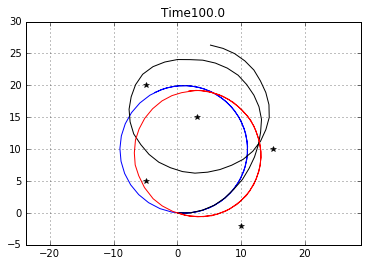

In [39]:
print(" start!!")

time = 0.0

# RFID positions [x, y, theta] These are the landmarks in the environment stcaked in to a Nx3 matrix
RFID = np.array([[10.0, -2.0, 0.0],
                 [15.0, 10.0, 0.0],
                 [3.0, 15.0, 0.0],
                 [-5.0, 20.0, 0.0],
                 [-5.0, 5.0, 0.0]
                 ])
#I will not be able to use these landmarks.

xTrue = np.matrix(np.zeros((STATE_SIZE, 1))) 
# State Vector [x y theta v]

xDR = np.matrix(np.zeros((STATE_SIZE, 1)))  
# Dead reckoning

# history of trajectory
hxTrue = xTrue
hxDR = xTrue
hz = []
dtime = 0.0

while SIM_TIME >= time: # while we have not reached the end of the simulation
    time += DT
    dtime += DT
    u = calc_input()
    # increment the time step and simulate the robot control input

    xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz.append(z)

    if dtime >= show_graph_dtime:
        x_opt = graph_based_slam(hxDR, hz)
        dtime = 0.0

        if show_animation:
            plt.cla()

            plt.plot(RFID[:, 0], RFID[:, 1], "*k")

            plt.plot(np.array(hxTrue[0, :]).flatten(),
                     np.array(hxTrue[1, :]).flatten(), "-b")
            plt.plot(np.array(hxDR[0, :]).flatten(),
                     np.array(hxDR[1, :]).flatten(), "-k")
            plt.plot(np.array(x_opt[0, :]).flatten(),
                     np.array(x_opt[1, :]).flatten(), "-r")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Time" + str(time)[0:5])
            plt.pause(1.0)